In [ ]:
import torch
import keras
from sklearn.model_selection import train_test_split

#IMDB 데이터셋 (num_words=500: 상위 500개 단어만 사용)
(train_input, train_target), (test_input, test_target) =\
     keras.datasets.imdb.load_data( num_words=500 )

#훈련세트, 검증세트 8:2 비율로 나눔
train_input, val_input, train_target, val_target = train_test_split(
    train_input, train_target, test_size=0.2, random_state=42
)


In [ ]:
# 패딩 처리 (시퀀스 길이를 동일하게 맞추기 위해 사용)
from keras.preprocessing.sequence import pad_sequences
# 시퀀스 길이를 100으로 맞춰서 패딩 처리
train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

In [ ]:
# 패딩 처리된 시퀀스 및 타겟 shape 확인
print(train_seq.shape, train_target.shape)

(20000, 100) (20000,)


In [ ]:
# 파이토치 torch.tensor 자료형으로 변환(PyTorch 학습 가능 형태로 변환)
train_seq = torch.tensor(train_seq)
val_seq = torch.tensor(val_seq)

In [12]:
train_target.dtype

dtype('int64')

In [ ]:
# 타겟을 float32로 변환 (BCELoss 사용을 위함, 정수 -> float)
train_target = torch.tensor(train_target, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

In [14]:
train_target.dtype

torch.float32

In [ ]:
# TensorDataset, DataLoader
from torch.utils.data import TensorDataset, DataLoader
# TensorDataset으로 (입력, 타겟) 묶음 생성
train_dataset = TensorDataset(train_seq, train_target)
val_dataset = TensorDataset(val_seq, val_target)

# DataLoader로 배치 크기 32, 셔플 적용하여 학습 데이터 로더 생성
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
# 층 구성 - nn.Module 클래스 상속을 통한 층 구성
import torch.nn as nn
# RNN 기반 IMDB 감성 분석 모델 정의
class IMDBRnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(500, 16)     # 단어 인덱스 0~499, 임베딩 16차원
        self.rnn = nn.RNN(16, 8, batch_first=True) # 입력크기 16, 은닉크기 8, 배치 우선
                                                   
        self.dense = nn.Linear(8,1) # 마지막 은닉 상태 8 -> 출력 1
        self.sigmoid = nn.Sigmoid() # 시그모이드로 이진 분류

    def forward(self, x):
        x = self.embedding(x) # 정수 인덱스 -> 임베딩 벡터
        _, hidden = self.rnn(x) # hidden: (num_layers * num_directions, batch, hidden_size)
        outputs = self.dense(hidden[-1]) # 마지막 레이어의 은닉 상태 사용
        return self.sigmoid(outputs) # 확률 출력

In [ ]:
# 모델 요약 확인
from torchinfo import summary
model = IMDBRnn()

summary(model)


Layer (type:depth-idx)                   Param #
IMDBRnn                                  --
├─Embedding: 1-1                         8,000
├─RNN: 1-2                               208
├─Linear: 1-3                            9
├─Sigmoid: 1-4                           --
Total params: 8,217
Trainable params: 8,217
Non-trainable params: 0

In [ ]:
# GPU 사용 가능 여부 확인 후 device 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

IMDBRnn(
  (embedding): Embedding(500, 16)
  (rnn): RNN(16, 8, batch_first=True)
  (dense): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# 옵티마이저, 손실함수
import torch.optim as optim

criterion = nn.BCELoss()  # 이진 교차 엔트로피 손실
optimizer = optim.Adam(model.parameters()) # Adam 최적화

In [ ]:
# 학습 기록 저장용 리스트 및 EarlyStopping 변수 초기화
train_hist = []
val_hist = []
patience = 3
best_loss = -1
early_stopping_counter = 0
# 학습 루프
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()   # 기울기 초기화
        outputs = model(inputs) # 순전파
        loss = criterion(outputs.squeeze(), targets) # 손실 계산, outputs.squeeze(): 2차원 배열 -> 1차원 배열
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()
        
    train_loss =  train_loss / len(train_loader) # 1에포크 평균 훈련 손실값
    val_loss = val_loss / len(val_loader)
    train_hist.append(train_loss)
    val_hist.append(val_loss)
    print(f"에포크:{epoch+1}, 훈련손실: {train_loss: .4f}, 검증손실: {val_loss:.4f}")
    
    # EarlyStopping 및 best 모델 저장
    if best_loss == -1 or val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
        torch.save(model.state_dict(), 'best_rnn_model.pt')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print(f"{epoch+1}에서 조기 종료..")
            break

에포크:1, 훈련손실:  0.6932, 검증손실: 0.6868
에포크:2, 훈련손실:  0.6810, 검증손실: 0.6758
에포크:3, 훈련손실:  0.6599, 검증손실: 0.6458
에포크:4, 훈련손실:  0.6508, 검증손실: 0.6736
에포크:5, 훈련손실:  0.6461, 검증손실: 0.6368
에포크:6, 훈련손실:  0.6272, 검증손실: 0.6245
에포크:7, 훈련손실:  0.6206, 검증손실: 0.6232
에포크:8, 훈련손실:  0.6105, 검증손실: 0.6237
에포크:9, 훈련손실:  0.6006, 검증손실: 0.6174
에포크:10, 훈련손실:  0.6083, 검증손실: 0.6137
에포크:11, 훈련손실:  0.6133, 검증손실: 0.6214
에포크:12, 훈련손실:  0.5961, 검증손실: 0.6062
에포크:13, 훈련손실:  0.5911, 검증손실: 0.6015
에포크:14, 훈련손실:  0.5814, 검증손실: 0.6043
에포크:15, 훈련손실:  0.5733, 검증손실: 0.5972
에포크:16, 훈련손실:  0.5749, 검증손실: 0.5961
에포크:17, 훈련손실:  0.5685, 검증손실: 0.6024
에포크:18, 훈련손실:  0.5713, 검증손실: 0.6006
에포크:19, 훈련손실:  0.5652, 검증손실: 0.6090
19에서 조기 종료..


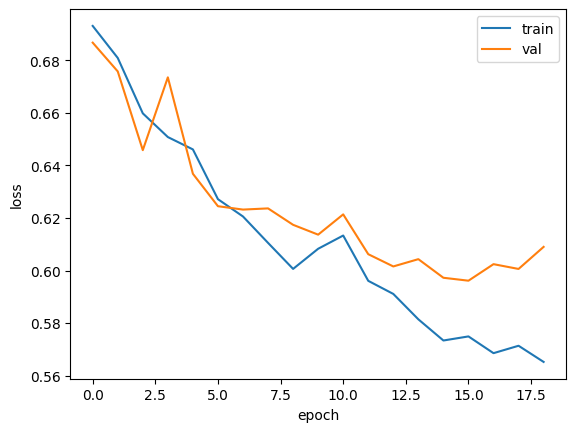

In [ ]:
import matplotlib.pyplot as plt # 학습/검증 손실 시각화

plt.plot(train_hist, label='train')
plt.plot(val_hist, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# 가장 성능이 좋았던 모델 로드
model.load_state_dict(torch.load('best_rnn_model.pt', weights_only=True))

<All keys matched successfully>

In [ ]:
# 검증 데이터셋 정확도 측정
model.eval()
corrects = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, taregts = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        predicts = outputs.squeeze() > 0.5  # 0.5 이상 True, 이하 False
        corrects += (predicts == targets).sum().item()

accuracy = corrects / len(val_dataset)
print(f"검증 정확도: {accuracy:.4f}")

검증 정확도: 0.6946


In [ ]:
# 메모리 흐름
# IMDB 데이터셋 구조, maxlen, Embedding, RNN hidden 구조 시각 설명
# 조기종료 시점 및 기준 해석
# 추가적인 정확도, 정밀도, 재현율, F1-score 출력 코드
# GPU 사용 상황별 속도 비교 시뮬레이션 설명